In [1]:
%cd ../

/Users/hoangle/Uni/Thesis


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from recbole.quick_start import run_recbole
from recbole.config import Config
from recbole.data import (
    create_dataset,
    data_preparation,
)
from recbole.utils import (
    init_logger,
    get_model,
    get_trainer,
    init_seed,
    set_color,
    get_flops,
    get_environment,
)
from recbole.quick_start import load_data_and_model

from src.real_temporal import TimeCutoffDataset

In [4]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

# Get suitable cutoff

In [57]:
def get_suitable_cutoff(ds_name: str) -> tuple:
    """Get suitable cutoff timestamp: at which there are the most active users

    Args:
        ds_name (str): dataset name

    Returns:
        tuple: suitable timestamp and the number of active users
    """

    # Get dataset without normalizing the timestamp
    config_dict = {
        'normalize_all': False,

        'load_col': {"inter": ['user_id', 'item_id', 'timestamp']},
        'train_neg_sample_args': None,
        'device': 'cpu',
        'use_gpu': False,

        'eval_args': {
            "order": "TO",
            "split": { "LS": "valid_and_test" },
            "group_by": None,
            'mode': 'full'
        },
    }
    config = Config(
        model='NPE',
        dataset=ds_name,
        config_dict=config_dict,
    )
    init_seed(config["seed"], config["reproducibility"])
    df = create_dataset(config).inter_feat.copy()

    # Create dataframe of users and corresponding first/last timestamp
    user_max_ts = df.groupby('user_id')['timestamp'].max()
    user_min_ts = df.groupby('user_id')['timestamp'].min()
    df_user = pd.DataFrame(
        {
            'max': user_max_ts,
            'min': user_min_ts,
        },
        index=user_max_ts.index
    )

    counts = defaultdict(int) 
    for ts in df_user['min']:
        counts[ts] += 1
    for ts in df_user['max']:
        counts[ts] -= 1

    timestamps = sorted(counts.keys())
    accum = {}

    s = 0
    for ts in timestamps:
        s += counts[ts]
        accum[ts] = s
    series = pd.Series(accum)

    suitable_ts = series.idxmax()
    max_active_user = series[suitable_ts]

    return suitable_ts, max_active_user

ds = "ml-100k"
# ds = "ml-1m"
# ds = "amazon-digital-music"
print(f"{ds}: {get_suitable_cutoff(ds)}")
# print(f"{ds}: {get_suitable_cutoff(ds)}")

ml-1m: (976324045.0, 1190)


/Users/macos/miniforge3/envs/thesis/lib/python3.10/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/Users/macos/miniforge3/envs/thesis/lib/python3.10/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on

/Users/macos/miniforge3/envs/thesis/lib/python3.10/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/Users/macos/miniforge3/envs/thesis/lib/python3.10/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on

train_dataset: 982089
valid_dataset: 6040
test_dataset : 6040


Text(0.5, 1.0, "Dataset 'ml-1m' (red is cutoff date)")

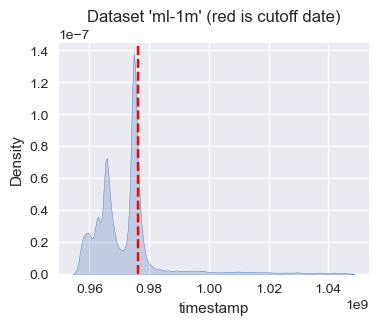

In [58]:
config_dict = {
    'normalize_all': False,

    'load_col': {"inter": ['user_id', 'item_id', 'timestamp']},
    'train_neg_sample_args': None,
    'device': 'cpu',
    'use_gpu': False,

    'eval_args': {
        "order": "TO",
        "split": { "LS": "valid_and_test" },
        "group_by": None,
        'mode': 'full'
    },
}
config = Config(
    model='NPE',
    dataset=ds,
    config_dict=config_dict,
)
init_seed(config["seed"], config["reproducibility"])
dataset = create_dataset(config)
df = dataset.inter_feat.copy()
train_data, valid_data, test_data = data_preparation(config, dataset)

print(f"train_dataset: {len(train_data.dataset)}")
print(f"valid_dataset: {len(valid_data.dataset)}")
print(f"test_dataset : {len(test_data.dataset)}")

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)

sns.kdeplot(df['timestamp'], ax=ax, fill=True)
plt.axvline(x = 976324045.0, color = 'r', linestyle = '--')
# plt.axvline(x = df['timestamp'].mean(), color = 'b', linestyle = '-.')
ax.set_title(f"Dataset '{ds}' (red is cutoff date)")

# Others

In [4]:
run_recbole(model='FM', dataset='ml-100k')

26 Jul 22:54    INFO  ['/Users/hoangle/miniforge3/envs/thesis/lib/python3.10/site-packages/ipykernel_launcher.py', '--f=/Users/hoangle/Library/Jupyter/runtime/kernel-v2-37605jUFTXXcz11GS.json']
26 Jul 22:54    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = /Users/hoangle/miniforge3/envs/thesis/lib/python3.10/site-packages/recbole/config/../dataset_example/ml-100k
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 300
train_batch_size = 2048
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}

KeyboardInterrupt: 

In [8]:
model = 'NeuMF'
dataset = 'amazon-digital-music'

config_dict = {
    # 'normalize_field': None,
    # 'normalize_all': False,
    # 'use_gpu': True,
    'gpu_id': 0,

    'train_batch_size': 1024,
    'eval_batch_size': 1024,

    'load_col': {"inter": ['user_id', 'item_id', 'timestamp']},
    'loss_type': 'CE',
    'train_neg_sample_args': None,
    # 'train_neg_sample_args': {
    #     'distribution': 'uniform',
    #     'sample_num': 30,
    #     'dynamic': False,
    #     'candidate_num': 0,
    # },
    'eval_args': {
        "order": "TO",
        "split": { "LS": "valid_and_test" },
        "group_by": None,
        'mode': "full"
    },
    # 'train_neg_sample_args': None
}

# config = Config(
#     model=model,
#     dataset=dataset,

#     config_dict=config_dict,
# )

# dataset = create_dataset(config)

run_recbole(model=model, dataset=dataset, config_dict=config_dict)

# dataset.inter_feat['timestamp']

12 Jul 17:33    INFO  ['/Users/macos/miniforge3/envs/thesis/lib/python3.10/site-packages/ipykernel_launcher.py', '--f=/Users/macos/Library/Jupyter/runtime/kernel-v2-88956x5UcV509Paw.json']
12 Jul 17:33    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = dataset/amazon-digital-music
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 300
train_batch_size = 1024
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'LS': 'valid_and_test'}, 'order': 'TO', 'group_by': None, 'mode': {'valid': 'full', 'test': 'full'}}
repeat

KeyError: 'neg_item_id'

## Load mode

In [8]:
path = "/Users/macos/Desktop/NPE-Jul-23-2024_08-37-18.pth"

# config, model, dataset, train_data, valid_data, test_data = load_data_and_model(model_file=path)
chkpt = torch.load(path, map_location=torch.device('cpu'))

config = chkpt['config']
config['device'] = torch.device('cpu')
config['use_gpu'] = False

if config["use_cutoff"] is True:
    dataset = TimeCutoffDataset(config)
else:
    dataset = create_dataset(config)
train_data, valid_data, test_data = data_preparation(config, dataset)

print(f"train_dataset: {len(train_data.dataset)}")
print(f"valid_dataset: {len(valid_data.dataset)}")
print(f"test_dataset : {len(test_data.dataset)}")

train_dataset: 935904
valid_dataset: 6035
test_dataset : 831


In [7]:
path = "/Users/macos/Desktop/NPE-Jul-23-2024_08-22-51.pth"

# config, model, dataset, train_data, valid_data, test_data = load_data_and_model(model_file=path)
chkpt = torch.load(path, map_location=torch.device('cpu'))

config = chkpt['config']
config['device'] = torch.device('cpu')
config['use_gpu'] = False

if config["use_cutoff"] is True:
    dataset = TimeCutoffDataset(config)
else:
    dataset = create_dataset(config)
train_data, valid_data, test_data = data_preparation(config, dataset)

print(f"train_dataset: {len(train_data.dataset)}")
print(f"valid_dataset: {len(valid_data.dataset)}")
print(f"test_dataset : {len(test_data.dataset)}")

/Users/macos/miniforge3/envs/thesis/lib/python3.10/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/Users/macos/miniforge3/envs/thesis/lib/python3.10/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on

train_dataset: 982089
valid_dataset: 6040
test_dataset : 6040


In [41]:
size_raw = {
  "amazon-digital": {
    "online_simulated": {
      "train_dataset": 133209,
      "valid_dataset": 31614,
      "test_dataset": 13479
    },
    "leave-one-out": {
      "train_dataset": 266800,
      "valid_dataset": 34157,
      "test_dataset": 56814
    }
  },
  "ml-1m": {
    "online_simulated": {
      "train_dataset": 832836,
      "valid_dataset": 5682,
      "test_dataset": 1190
    },
    "leave-one-out": {
      "train_dataset": 982089,
      "valid_dataset": 6040,
      "test_dataset": 6040
    }
  }
}

sizes = []
for ds_name, v in size_raw.items():
    for scheme, v1 in v.items():
        for split, size in v1.items():
            sizes.append({
                'dataset': ds_name,
                'scheme': scheme,
                'split': split,
                'size': size
            })

df_sizes = pd.DataFrame.from_records(sizes)
df_sizes.head()

,dataset,scheme,split,size
0,amazon-digital,online_simulated,train_dataset,133209
1,amazon-digital,online_simulated,valid_dataset,31614
2,amazon-digital,online_simulated,test_dataset,13479
3,amazon-digital,leave-one-out,train_dataset,266800
4,amazon-digital,leave-one-out,valid_dataset,34157


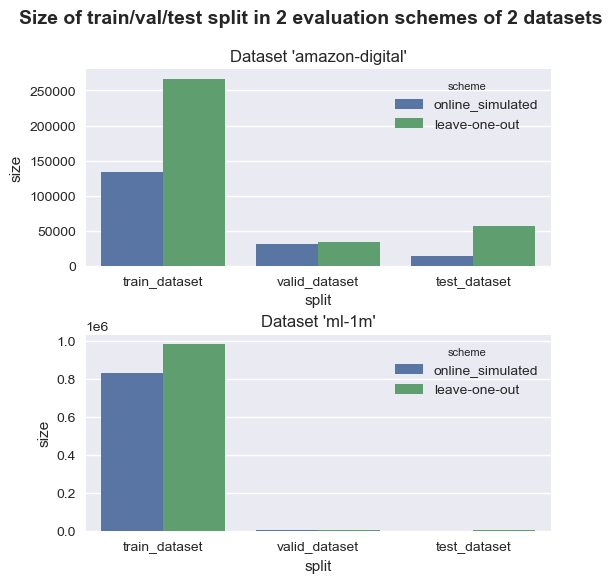

In [60]:
fig = plt.figure(figsize=(6, 6))
fig.suptitle("Size of train/val/test split in 2 evaluation schemes of 2 datasets", fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.35)

for i, dataset in enumerate(df_sizes['dataset'].unique()):
    df = df_sizes[df_sizes['dataset'] == dataset]

    ax = fig.add_subplot(2, 1, i+1)
    sns.barplot(df, x='split', y='size', hue='scheme', ax=ax)
    ax.set_title(f"Dataset '{dataset}'")